# Import necessary modules

In [24]:
# Modules to ignore warnings
import warnings               
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import os   
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import call

In [25]:
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import to_categorical
import cv2
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [26]:
FAST_RUN = False
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_CHANNELS = 3 # RGB color
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

# Reading Data

In [27]:
# Dictionary: key - folder name, value - Category
class_map = {'c0': 'airplanes',
            'c1': 'BACKGROUND_Google',
            'c2': 'bonsai',
            'c3': 'car_side',
            'c4': 'Faces',
            'c5': 'Faces_easy',
            'c6': 'grand_piano',
            'c7': 'Leopards',
            'c8': 'Motorbikes',
            'c9': 'watch'}

In [28]:
train_path = 'E:/Insofe/Python Lab//10_categories/'   # Train data path
val_path = 'E:/Insofe/Python Lab/10_cat_output/'       # Validation data path
classes = os.listdir(train_path)                                   # List of directories in train path
print(classes)

['airplanes', 'BACKGROUND_Google', 'bonsai', 'car_side', 'Faces', 'Faces_easy', 'grand_piano', 'Leopards', 'Motorbikes', 'watch']


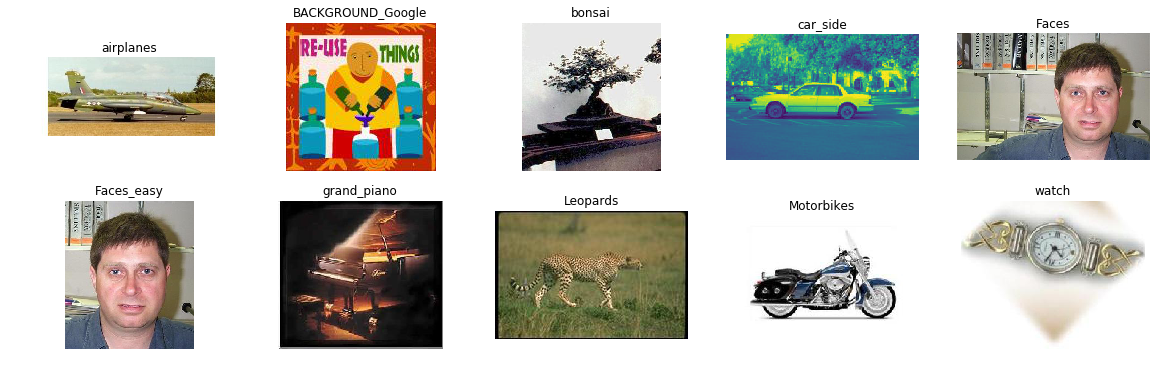

In [29]:
# Plot a sample image from each category

plt.figure(figsize=(20,6))
for ix,i in enumerate(classes):
    f = os.listdir(os.path.join(train_path,i))[0]
    img = mpimg.imread(os.path.join(train_path,i,f))
    plt.subplot(2,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)

In [30]:
filenames = []
categories = []
X = []
for ix,i in enumerate(classes):
    writename = os.listdir(os.path.join(train_path,i))
    count = 0
    while(count < len(writename)):
        img_path = os.path.join(train_path,i,writename[count])
        img = load_img(img_path)   # this is a PIL image
        img_X = img_to_array(img) # this is a Numpy array with shape (480, 640, 3)
        new_array = cv2.resize(img_X, (IMAGE_SIZE),interpolation=cv2.INTER_CUBIC)
        new_array= new_array.reshape(150,150,3)
        X.append(new_array)
        file_name = writename[count]
        filename =  img_path
        filenames.append(filename)
        count = count + 1
        if i == 'airplanes':
            categories.append('C0')
        elif i == 'BACKGROUND_Google':
            categories.append('C1')
        elif i == 'bonsai':
            categories.append('C2')
        elif i == 'car_side':
            categories.append('C3')
        elif i == 'Faces':
            categories.append('C4')
        elif i == 'Faces_easy':
            categories.append('C5')
        elif i == 'grand_piano':
            categories.append('C6')
        elif i == 'Leopards':
            categories.append('C7')
        elif i == 'Motorbikes':
            categories.append('C8')
        elif i == 'watch':
            categories. append('C9')
        else:
            pass

In [31]:
print(len(categories))
print(len(filenames))
df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})
from sklearn.utils import shuffle
df = shuffle(df)

3724
3724


In [32]:
# one-hot encoding for 10-different classes
y = pd.get_dummies(df['category'])



In [33]:
X = np.array(X)
y = np.array(y)
print(X.shape,y.shape)
print(y)

(3724, 150, 150, 3) (3724, 10)
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [34]:
# Lets split the data into trin and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 2)

In [35]:
import random
import gc
# Clear memory
del X
del y
gc.collect()

# get the length of train and validation data
ntrain = len(X_train)
nval = len(X_val)
#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32  

In [47]:
from keras.applications import InceptionResNetV2
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [48]:
conv_base.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_458 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_458 (BatchN (None, 74, 74, 32)   96          conv2d_458[0][0]                 
__________________________________________________________________________________________________
activation_457 (Activation)     (None, 74, 74, 32)   0           batch_normalization_458[0][0]    
__________________________________________________________________________________________________
conv2d_459

__________________________________________________________________________________________________
batch_normalization_569 (BatchN (None, 7, 7, 192)    576         conv2d_569[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, 7, 7, 192)    0           batch_normalization_566[0][0]    
__________________________________________________________________________________________________
activation_568 (Activation)     (None, 7, 7, 192)    0           batch_normalization_569[0][0]    
__________________________________________________________________________________________________
block17_9_mixed (Concatenate)   (None, 7, 7, 384)    0           activation_565[0][0]             
                                                                 activation_568[0][0]             
__________________________________________________________________________________________________
block17_9_

__________________________________________________________________________________________________
block8_2_conv (Conv2D)          (None, 3, 3, 2080)   933920      block8_2_mixed[0][0]             
__________________________________________________________________________________________________
block8_2 (Lambda)               (None, 3, 3, 2080)   0           block8_1_ac[0][0]                
                                                                 block8_2_conv[0][0]              
__________________________________________________________________________________________________
block8_2_ac (Activation)        (None, 3, 3, 2080)   0           block8_2[0][0]                   
__________________________________________________________________________________________________
conv2d_630 (Conv2D)             (None, 3, 3, 192)    399360      block8_2_ac[0][0]                
__________________________________________________________________________________________________
batch_norm

In [50]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation = 'relu'))
model.add(layers.Dense(10,activation = 'softmax')) #Softmax function at the end because we have 10 classes

In [51]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 492
Number of trainable weights after freezing the conv base: 4


In [52]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use 'categorical_crossentropy' loss because its a 10 class classification
from keras import optimizers
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5),metrics=['accuracy'])

In [53]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale = 1./255, # Scale the image between 0 and 1
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255)  #We do not augment validation data. we only perform rescale

In [54]:
# Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val,y_val, batch_size=batch_size)

In [55]:
# The training part
#We train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                             steps_per_epoch = ntrain // batch_size,
                             epochs = 3,
                             validation_data = val_generator,
                             validation_steps = nval // batch_size)

Epoch 1/3
93/93 [==============================] - 894s 10s/step - loss: 2.2220 - acc: 0.1868 - val_loss: 2.9586 - val_acc: 0.2120
Epoch 2/3
93/93 [==============================] - 734s 8s/step - loss: 2.1467 - acc: 0.2116 - val_loss: 3.0117 - val_acc: 0.2216
Epoch 3/3
93/93 [==============================] - 25370s 273s/step - loss: 2.1453 - acc: 0.2161 - val_loss: 2.8343 - val_acc: 0.1725


In [45]:
#Save the model
model.save_weights('model_wieghts_10class_inception.h5')
model.save('model_keras_10class_inception.h5')

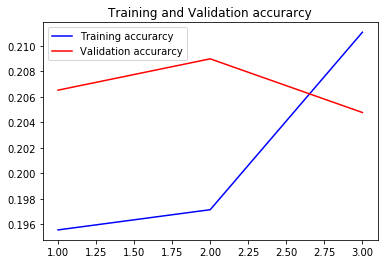

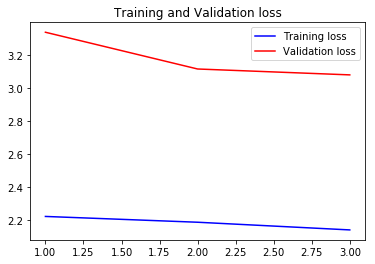

In [46]:
#lets plot the train and val curve
import matplotlib.pyplot as plt

#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

In [ ]:
#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

In [ ]:
#Now lets predict on the first 10 Images of the test set
X_test, y_test = read_and_process_image(test_imgs[0:10]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
i = 0
columns = 5
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('dog')
    else:
        text_labels.append('cat')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

## Predictions

In [28]:
# val_generator.filenames

In [22]:
val_preds = model.predict_generator(generator=val_generator)

In [23]:
val_preds_class = val_preds.argmax(axis=1)
val_preds_df = pd.DataFrame({'image':val_generator.filenames, 'prediction':val_preds_class})
val_preds_df.head(10)

,image,prediction
0,c0/img_100026.jpg,0
1,c0/img_10012.jpg,0
2,c0/img_1005.jpg,0
3,c0/img_100542.jpg,0
4,c0/img_100656.jpg,0
5,c0/img_100665.jpg,0
6,c0/img_100796.jpg,0
7,c0/img_100824.jpg,0
8,c0/img_101015.jpg,0
9,c0/img_101383.jpg,0


In [24]:
val_generator.class_indices

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

## Incorrect Predictions

In [25]:
val_incorrect_pred = [i for i in val_preds_df.index.values if int(val_preds_df.image.values[i].split('/')[0][1])!=val_preds_df.prediction.values[i]]
# val_incorrect_pred = [i for i,j in zip(val_preds_df.image.values,val_preds_df.prediction.values) if int(i.split('/')[0][1])!=j]

In [26]:
val_incorrect_pred

[35, 276, 339, 922, 2458, 3452, 3506, 3934]

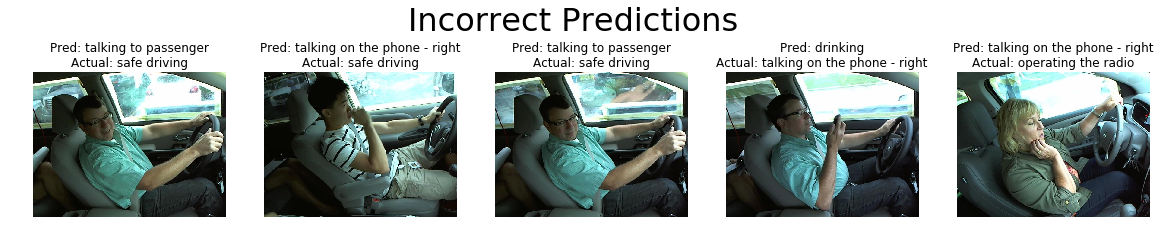

In [33]:
plt.figure(figsize=(20,4))
plt.suptitle("Incorrect Predictions", size=32)
for ix,i in enumerate(val_incorrect_pred):
    img = mpimg.imread(os.path.join('val',val_preds_df.image[i]))
    plt.subplot(1,5,ix+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Pred: '+class_map['c'+str(val_preds_df.prediction[i])]+'\n'+'Actual: '+class_map[val_preds_df.image[i].split('/')[0]])
    if ix==4:
        break